# Comprehensive Evaluation of Community Detection Methods

This notebook provides a comprehensive evaluation of all the community detection methods we've explored in this series. We'll:

1. Load results from previous notebooks
2. Compare the performance of different methods
3. Analyze the strengths and weaknesses of each method
4. Visualize the results
5. Generate a summary report

In [1]:
import sys
import os
import numpy as np
import torch
import polars as pl
import rustworkx as rx
import networkx as nx  # Still needed for some algorithms and visualization
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import time
import warnings
warnings.filterwarnings('ignore')

# Import visualization functions from community_detection package
from community_detection.visualization import visualize_overlapping_communities, plot_overlapping_communities

# Import from evaluation module in the community_detection package
from community_detection.evaluation import save_result

# Import overlapping community detection functions from the community_detection package
from community_detection.overlapping_community_detection import (
    generate_synthetic_overlapping_graph, run_bigclam, run_demon, run_slpa,
    evaluate_overlapping_communities, GNN_Overlapping, run_gnn_overlapping
)

Note: to be able to use all crisp methods, you need to install some additional packages:  {'graph_tool'}


2025-03-31 17:09:23.532736: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743455363.546785  630298 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743455363.551083  630298 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1743455363.562108  630298 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1743455363.562120  630298 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1743455363.562121  630298 computation_placer.cc:177] computation placer alr

## 1. Check Required Libraries

Let's check if the required libraries for overlapping community detection are available.

In [2]:
# Check if cdlib is available for traditional overlapping methods
try:
    from cdlib import algorithms, evaluation as cdlib_eval
    from cdlib.classes import NodeClustering
    CDLIB_AVAILABLE = True
    print("cdlib is available.")
except ImportError:
    CDLIB_AVAILABLE = False
    print("cdlib is not available. Some methods will be skipped.")
    print("You can install it with: pip install cdlib")

# Check if PyTorch Geometric is available for GNN-based methods
try:
    import torch_geometric
    from torch_geometric.data import Data
    from torch_geometric.nn import GCNConv
    TORCH_GEOMETRIC_AVAILABLE = True
    print("PyTorch Geometric is available.")
except ImportError:
    TORCH_GEOMETRIC_AVAILABLE = False
    print("PyTorch Geometric is not available. GNN-based methods will be skipped.")
    print("You can install it with: pip install torch-geometric")

cdlib is available.
PyTorch Geometric is available.


## 2. Define Functions for Overlapping Community Detection

Let's define the necessary functions for generating and analyzing overlapping communities.

In [3]:
# We'll just use the functions from the community_detection package
# No need to redefine them here, as they are already imported
print("Using functions from the community_detection package:")
print("- generate_synthetic_overlapping_graph")
print("- run_bigclam")
print("- run_demon")
print("- run_slpa")
print("- evaluate_overlapping_communities")
print("- GNN_Overlapping")
print("- run_gnn_overlapping")

Using functions from the community_detection package:
- generate_synthetic_overlapping_graph
- run_bigclam
- run_demon
- run_slpa
- evaluate_overlapping_communities
- GNN_Overlapping
- run_gnn_overlapping


## 3. Generate a Synthetic Graph with Overlapping Communities

Let's create a synthetic graph with overlapping communities for our experiments.

Generating a synthetic graph with overlapping communities...
Generated graph with 100 nodes and 710 edges.
Created 4 overlapping communities.

Visualizing ground truth overlapping communities...


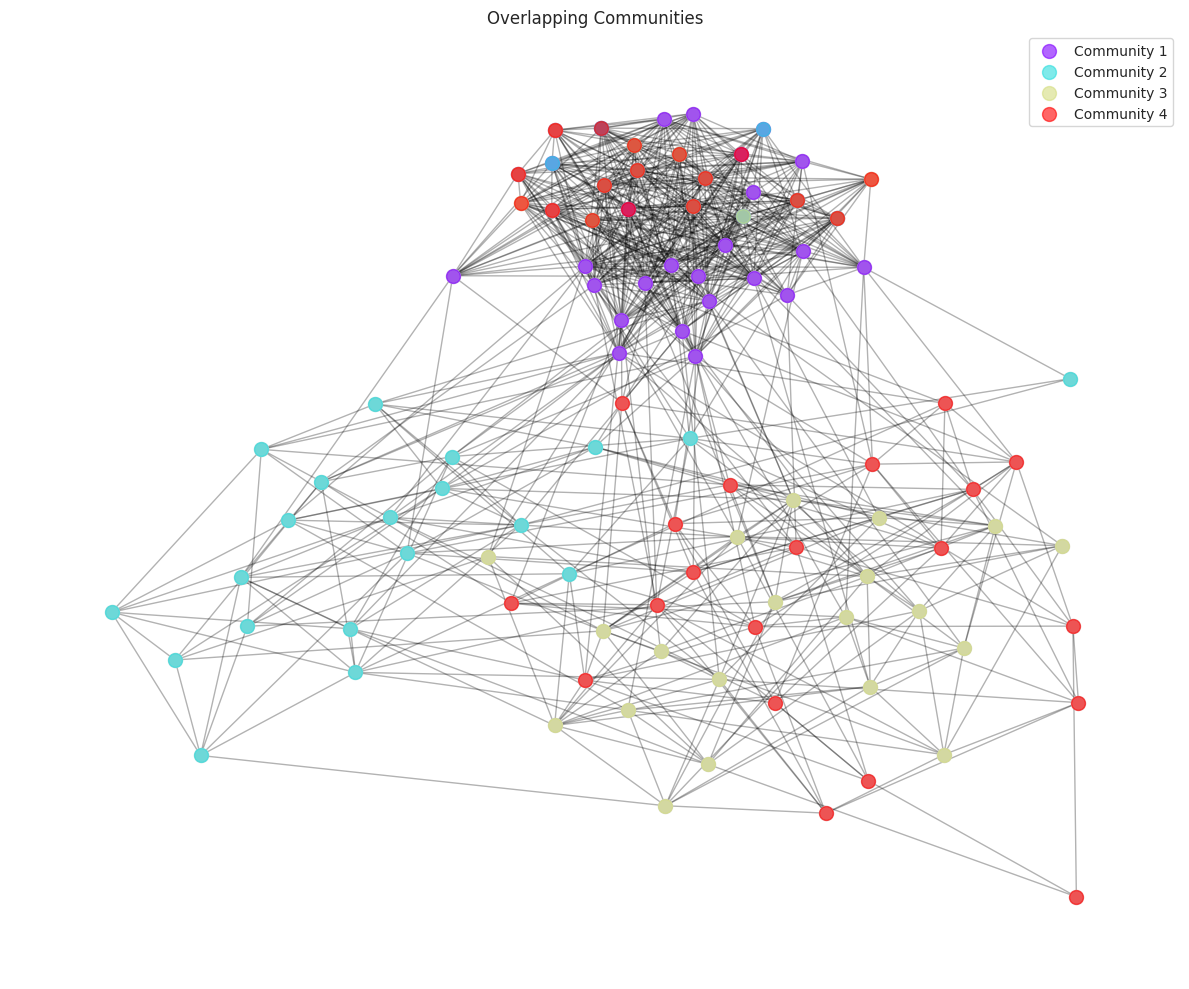

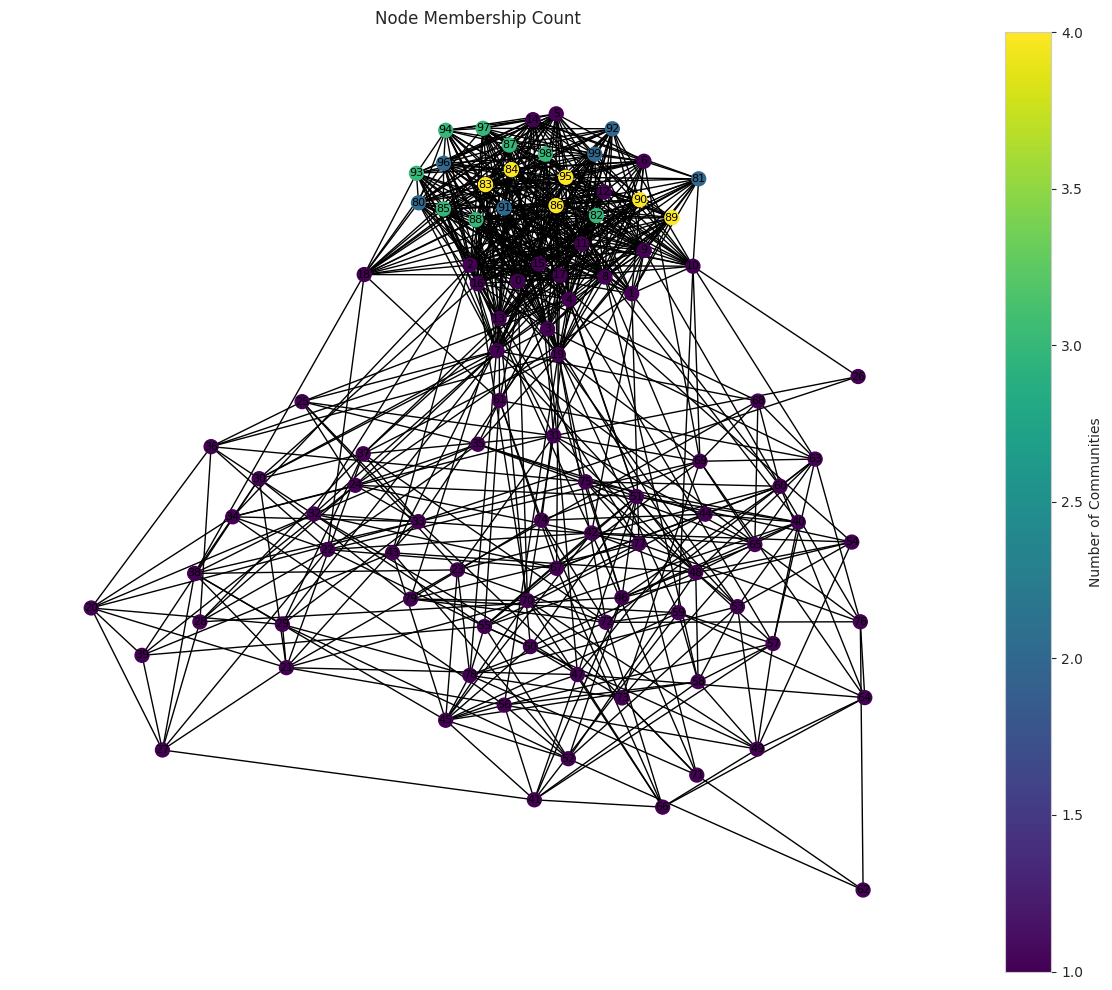

In [4]:
# Generate a synthetic graph with overlapping communities
print("Generating a synthetic graph with overlapping communities...")
n_communities = 4
n_nodes = 100
overlap_size = 20  # Number of nodes that will belong to multiple communities

G, ground_truth = generate_synthetic_overlapping_graph(
    n_nodes=n_nodes,
    n_communities=n_communities,
    overlap_size=overlap_size,
    p_in=0.3,  # probability of edge within community
    p_out=0.05  # probability of edge between communities
)

print(f"Generated graph with {len(G)} nodes and {G.num_edges()} edges.")
print(f"Created {n_communities} overlapping communities.")

# Visualize the ground truth overlapping communities
print("\nVisualizing ground truth overlapping communities...")
visualize_overlapping_communities(G, ground_truth, figsize=(12, 10), alpha=0.6)

## 4. Analyze Overlapping Community Structure

Let's analyze the structure of our overlapping communities to better understand them.

Analyzing ground truth overlapping communities:
Community sizes: [35, 33, 35, 37]

Membership distribution (number of nodes with N community memberships):
  80 nodes belong to 1 communities
  6 nodes belong to 2 communities
  8 nodes belong to 3 communities
  6 nodes belong to 4 communities


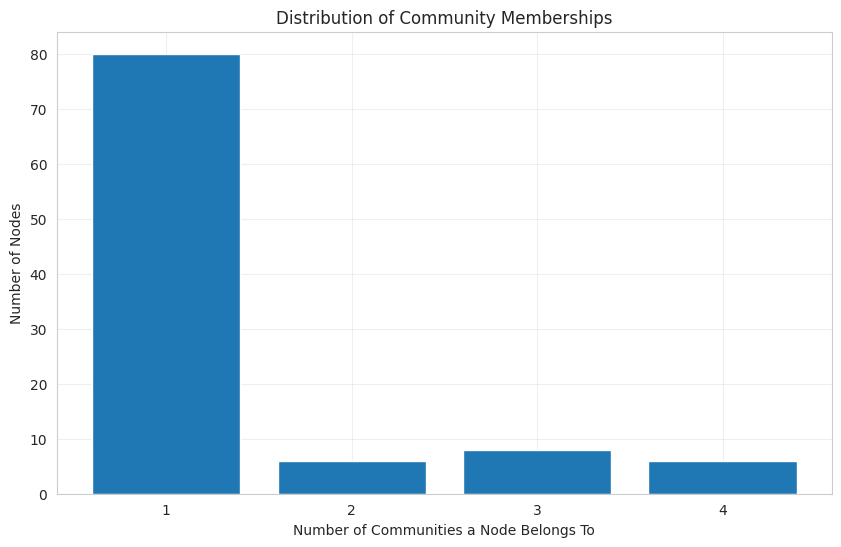


Overlap between communities:
  Communities 0 and 1 share 10 nodes
  Communities 0 and 2 share 10 nodes
  Communities 0 and 3 share 12 nodes
  Communities 1 and 2 share 10 nodes
  Communities 1 and 3 share 10 nodes
  Communities 2 and 3 share 14 nodes


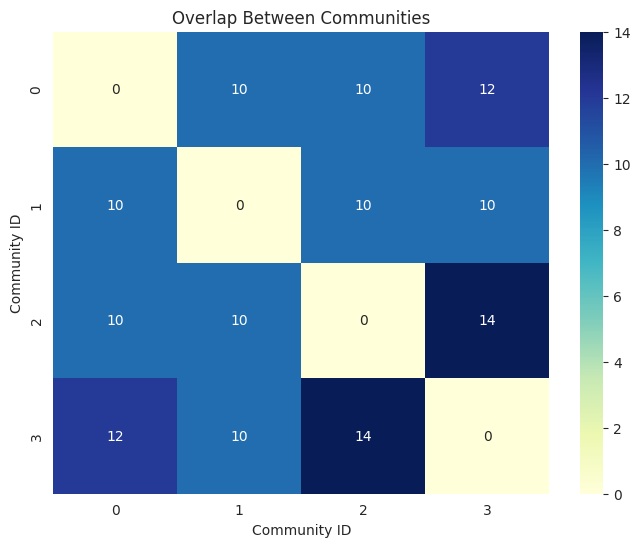

In [5]:
# Analyze ground truth overlapping communities
print("Analyzing ground truth overlapping communities:")

# Count community sizes
community_sizes = [len(comm) for comm in ground_truth]
print(f"Community sizes: {community_sizes}")

# Count number of communities per node
node_memberships = {}
for i, comm in enumerate(ground_truth):
    for node in comm:
        if node not in node_memberships:
            node_memberships[node] = []
        node_memberships[node].append(i)

membership_counts = {node: len(comms) for node, comms in node_memberships.items()}
membership_distribution = {}
for count in membership_counts.values():
    if count not in membership_distribution:
        membership_distribution[count] = 0
    membership_distribution[count] += 1

print("\nMembership distribution (number of nodes with N community memberships):")
for count, num_nodes in sorted(membership_distribution.items()):
    print(f"  {num_nodes} nodes belong to {count} communities")

# Plot the distribution of community memberships
plt.figure(figsize=(10, 6))
plt.bar(membership_distribution.keys(), membership_distribution.values())
plt.title('Distribution of Community Memberships')
plt.xlabel('Number of Communities a Node Belongs To')
plt.ylabel('Number of Nodes')
plt.xticks(range(1, max(membership_distribution.keys()) + 1))
plt.grid(alpha=0.3)
plt.show()

# Analyze overlap between communities
print("\nOverlap between communities:")
overlap_matrix = np.zeros((n_communities, n_communities))
for i in range(n_communities):
    for j in range(i+1, n_communities):
        overlap = len(set(ground_truth[i]) & set(ground_truth[j]))
        overlap_matrix[i, j] = overlap
        overlap_matrix[j, i] = overlap
        print(f"  Communities {i} and {j} share {overlap} nodes")

# Visualize the overlap matrix
plt.figure(figsize=(8, 6))
sns.heatmap(overlap_matrix, annot=True, fmt=".0f", cmap="YlGnBu")
plt.title('Overlap Between Communities')
plt.xlabel('Community ID')
plt.ylabel('Community ID')
plt.show()

## 5. BigCLAM Algorithm

BigCLAM (Cluster Affiliation Model for Big Networks) is designed to detect overlapping communities in large networks.

Running BigCLAM algorithm...
karateclub not available, using custom BigClam implementation
Using custom metric implementation for overlapping community evaluation...
Metrics: F1=0.5594, Omega=0.3308
Execution time: 0.5825 seconds
Number of communities detected: 4
NMI: 0.3308
Omega Index: 0.3308
F1 Score: 0.5594

Visualizing BigCLAM detected communities...


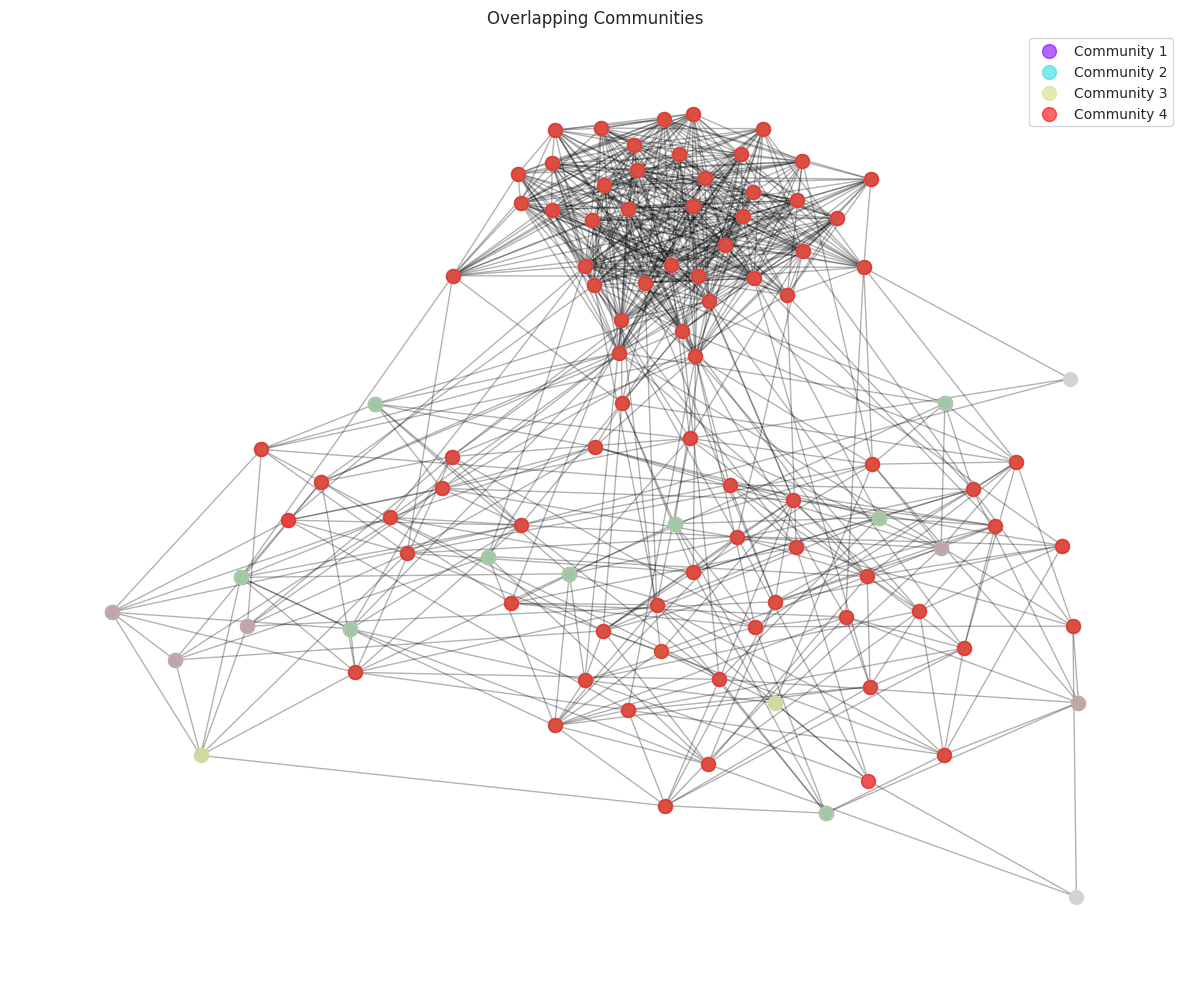

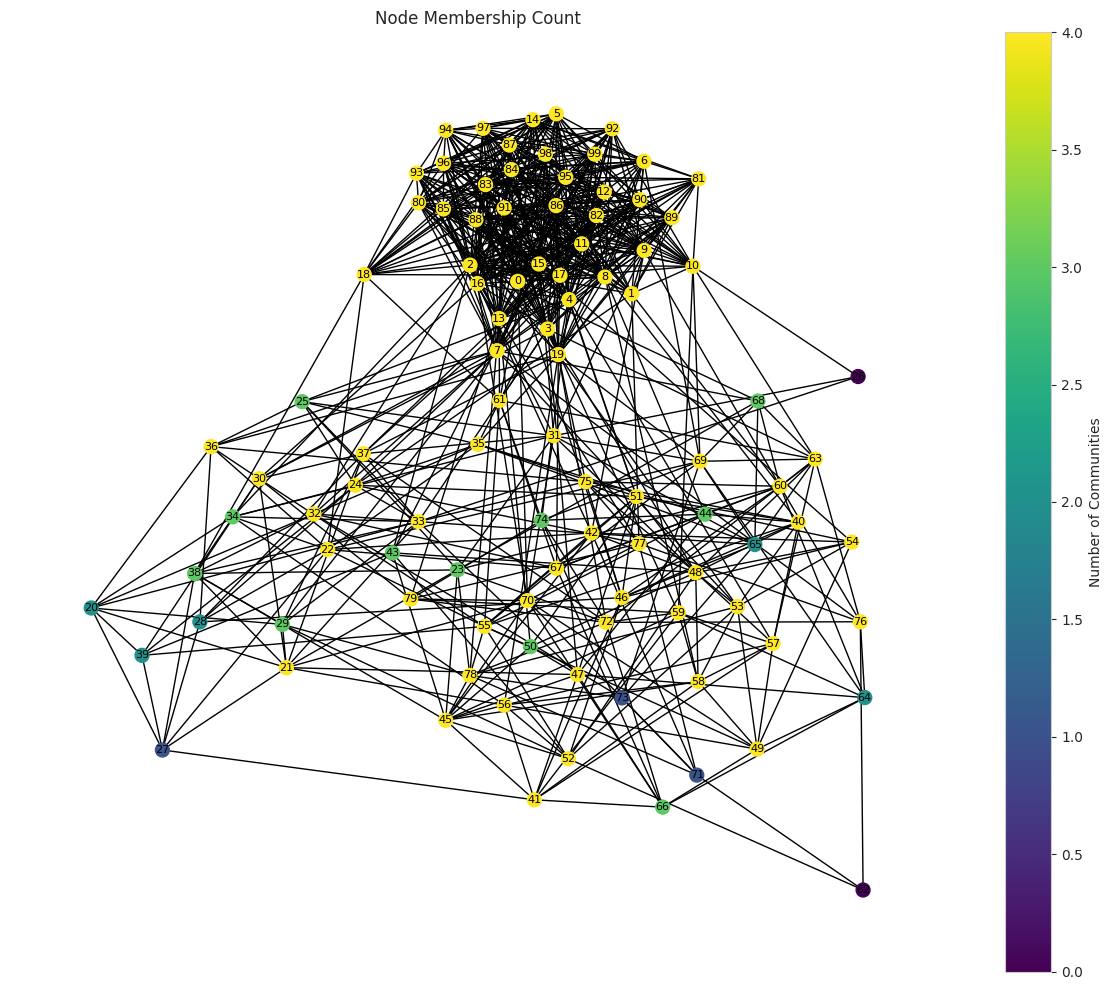

In [6]:
if CDLIB_AVAILABLE:
    # Run BigCLAM algorithm
    print("Running BigCLAM algorithm...")
    
    # Set the number of communities to detect
    k = len(ground_truth)
    
    # Run BigCLAM
    bigclam_communities, bigclam_time = run_bigclam(G, k=k)
    
    # Evaluate against ground truth
    bigclam_metrics = evaluate_overlapping_communities(bigclam_communities, ground_truth)
    print(f"Execution time: {bigclam_time:.4f} seconds")
    print(f"Number of communities detected: {len(bigclam_communities)}")
    print(f"NMI: {bigclam_metrics['nmi']:.4f}")
    print(f"Omega Index: {bigclam_metrics['omega']:.4f}")
    print(f"F1 Score: {bigclam_metrics['f1']:.4f}")
    
    # Save results
    bigclam_result = {
        'communities': bigclam_communities,
        'execution_time': bigclam_time,
        'metrics': bigclam_metrics,
        'num_communities': len(bigclam_communities)
    }
    os.makedirs('results', exist_ok=True)
    with open('results/bigclam_result.pkl', 'wb') as f:
        pickle.dump(bigclam_result, f)
    
    # Visualize detected communities
    print("\nVisualizing BigCLAM detected communities...")
    visualize_overlapping_communities(G, bigclam_communities, figsize=(12, 10), alpha=0.6)
else:
    print("BigCLAM requires cdlib. Skipping this method.")

## 6. DEMON Algorithm

DEMON (Democratic Estimate of the Modular Organization of a Network) leverages local community information to identify overlapping communities.

Running DEMON algorithm...
Trying DEMON with just epsilon parameter...
Using custom metric implementation for overlapping community evaluation...
Metrics: F1=0.4825, Omega=0.3167
Execution time: 0.0797 seconds
Number of communities detected: 2
NMI: 0.3167
Omega Index: 0.3167
F1 Score: 0.4825

Visualizing DEMON detected communities...


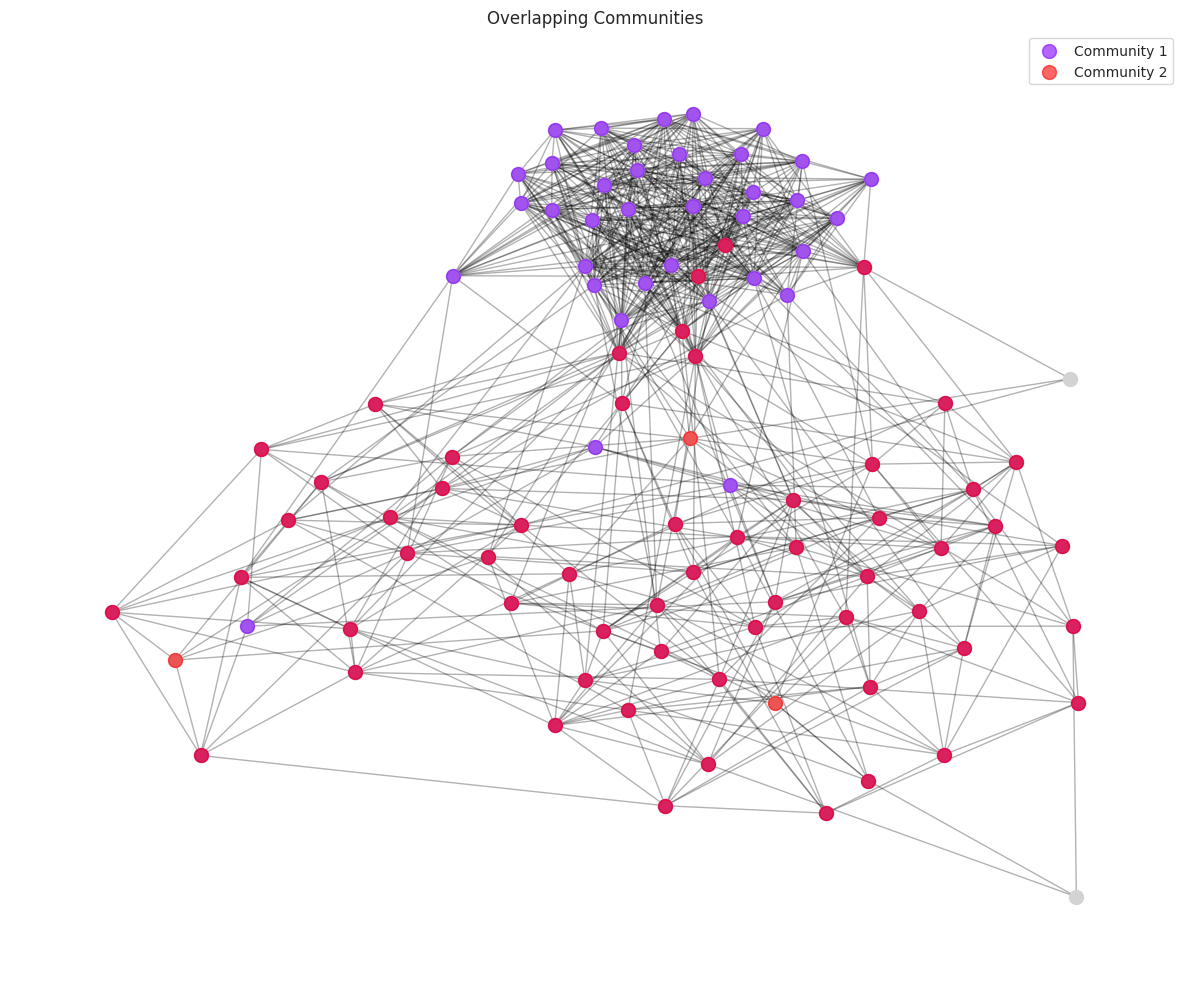

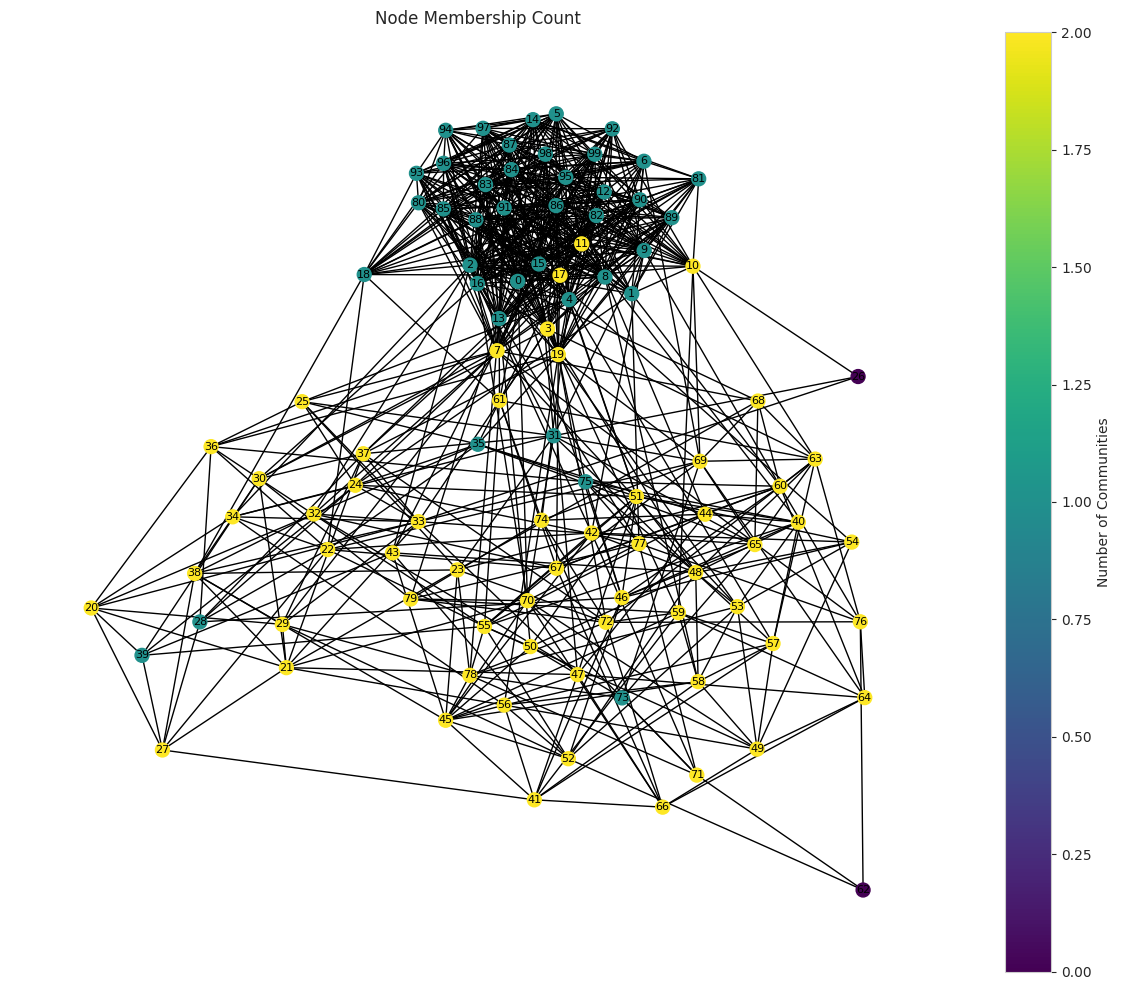

In [7]:
if CDLIB_AVAILABLE:
    # Run DEMON algorithm
    print("Running DEMON algorithm...")
    
    # Run DEMON
    demon_communities, demon_time = run_demon(G, epsilon=0.25)
    
    # Evaluate against ground truth
    demon_metrics = evaluate_overlapping_communities(demon_communities, ground_truth)
    print(f"Execution time: {demon_time:.4f} seconds")
    print(f"Number of communities detected: {len(demon_communities)}")
    print(f"NMI: {demon_metrics['nmi']:.4f}")
    print(f"Omega Index: {demon_metrics['omega']:.4f}")
    print(f"F1 Score: {demon_metrics['f1']:.4f}")
    
    # Save results
    demon_result = {
        'communities': demon_communities,
        'execution_time': demon_time,
        'metrics': demon_metrics,
        'num_communities': len(demon_communities)
    }
    with open('results/demon_result.pkl', 'wb') as f:
        pickle.dump(demon_result, f)
    
    # Visualize detected communities
    print("\nVisualizing DEMON detected communities...")
    visualize_overlapping_communities(G, demon_communities, figsize=(12, 10), alpha=0.6)
else:
    print("DEMON requires cdlib. Skipping this method.")

## 7. SLPA Algorithm

Speaker-Listener Label Propagation Algorithm (SLPA) is an extension of Label Propagation that can detect overlapping communities.

Running SLPA algorithm...
Trying SLPA with standard parameters...
✓ Success!
Using custom metric implementation for overlapping community evaluation...
Metrics: F1=0.5401, Omega=0.2517
Execution time: 0.1194 seconds
Number of communities detected: 1
NMI: 0.2517
Omega Index: 0.2517
F1 Score: 0.5401

Visualizing SLPA detected communities...


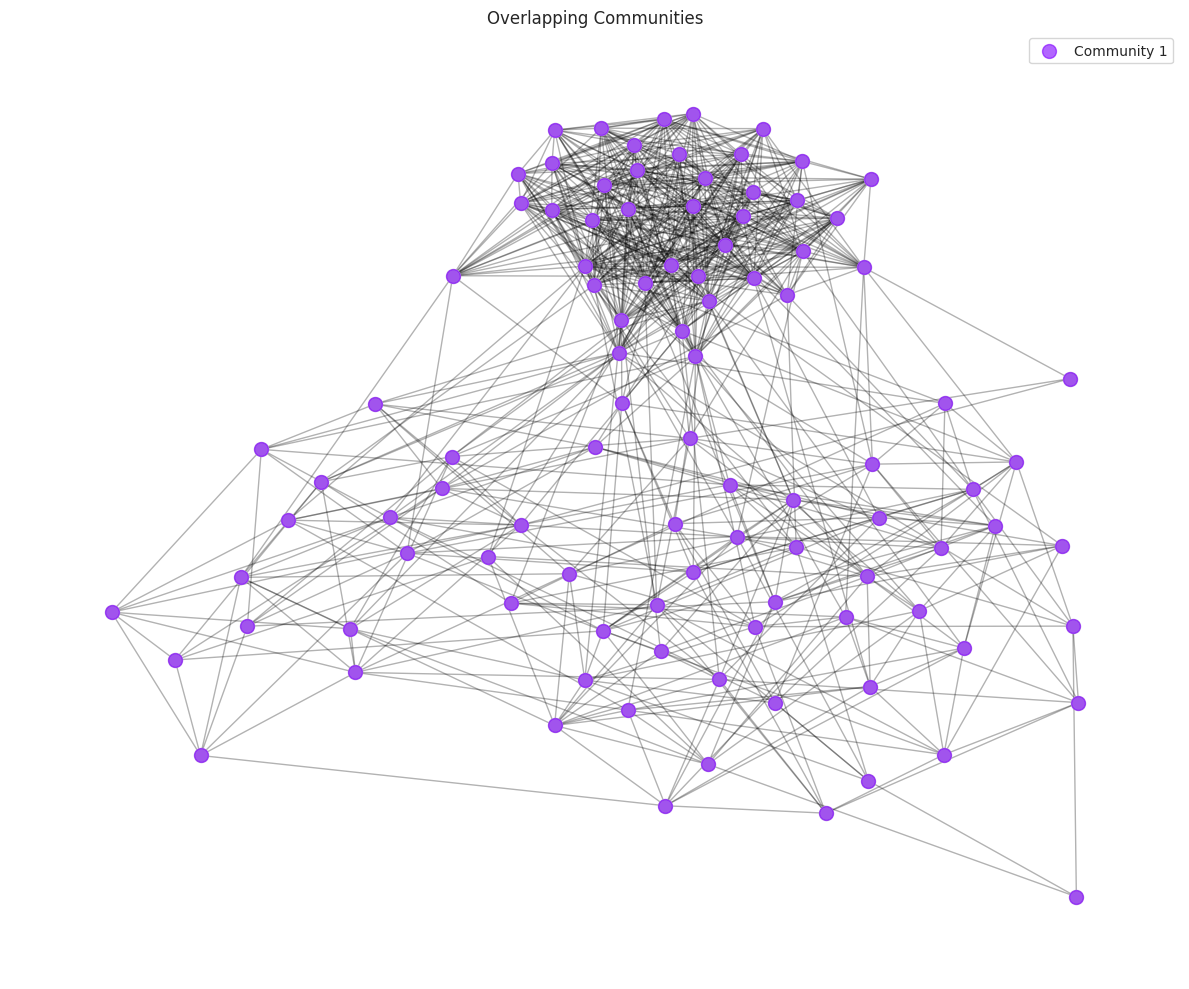

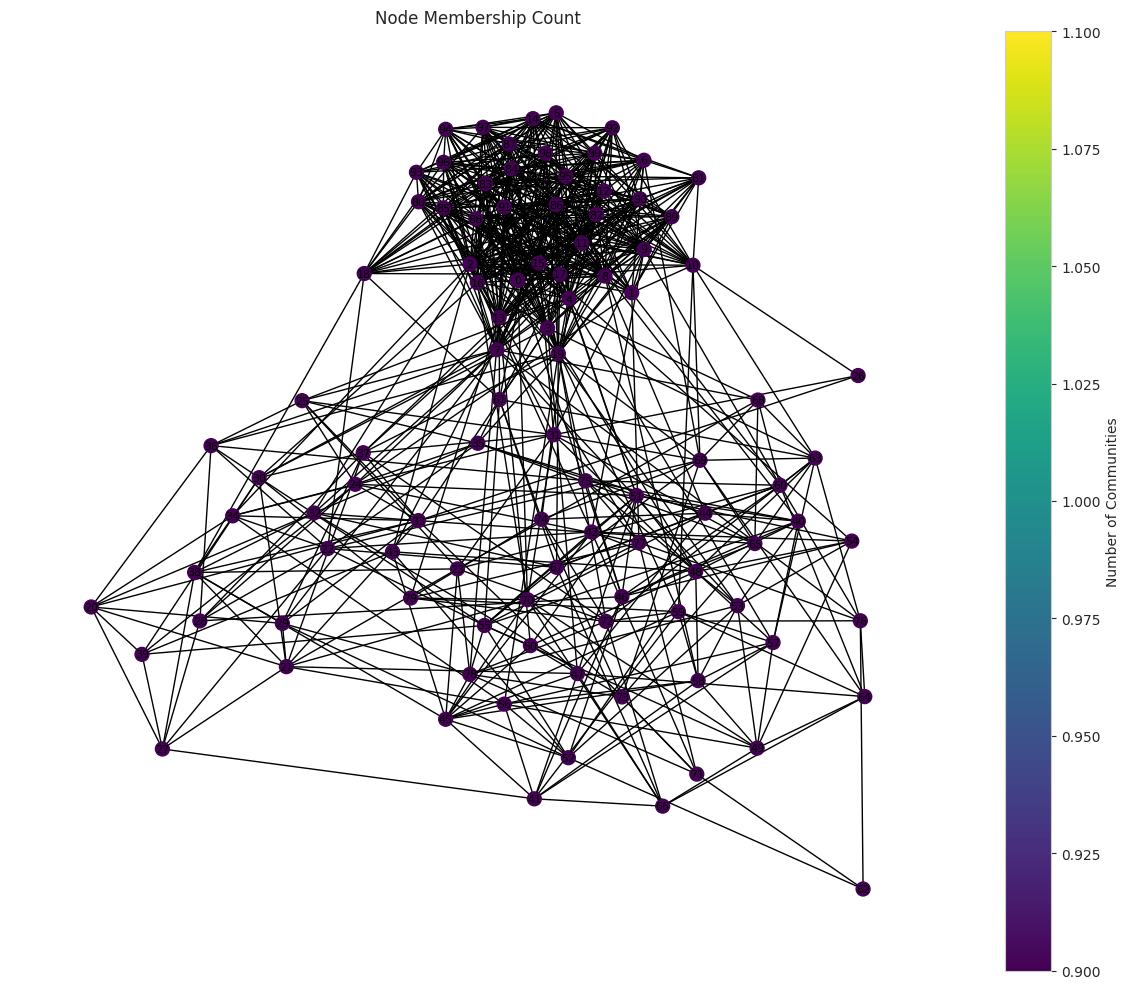

In [8]:
if CDLIB_AVAILABLE:
    # Run SLPA algorithm
    print("Running SLPA algorithm...")
    
    # Run SLPA
    slpa_communities, slpa_time = run_slpa(G, t=21, r=0.1)
    
    # Evaluate against ground truth
    slpa_metrics = evaluate_overlapping_communities(slpa_communities, ground_truth)
    print(f"Execution time: {slpa_time:.4f} seconds")
    print(f"Number of communities detected: {len(slpa_communities)}")
    print(f"NMI: {slpa_metrics['nmi']:.4f}")
    print(f"Omega Index: {slpa_metrics['omega']:.4f}")
    print(f"F1 Score: {slpa_metrics['f1']:.4f}")
    
    # Save results
    slpa_result = {
        'communities': slpa_communities,
        'execution_time': slpa_time,
        'metrics': slpa_metrics,
        'num_communities': len(slpa_communities)
    }
    with open('results/slpa_result.pkl', 'wb') as f:
        pickle.dump(slpa_result, f)
    
    # Visualize detected communities
    print("\nVisualizing SLPA detected communities...")
    visualize_overlapping_communities(G, slpa_communities, figsize=(12, 10), alpha=0.6)
else:
    print("SLPA requires cdlib. Skipping this method.")

## 8. GNN-Based Overlapping Community Detection

Let's implement a GNN-based approach for detecting overlapping communities.

Running GNN-based overlapping community detection...
Epoch 10/100, Loss: 0.6080
Epoch 20/100, Loss: 0.5255
Epoch 30/100, Loss: 0.5220
Epoch 40/100, Loss: 0.4971
Epoch 50/100, Loss: 0.4443
Epoch 60/100, Loss: 0.4265
Epoch 70/100, Loss: 0.4054
80/100, Loss: 0.3545
Epoch 20/100, Loss: 0.5255
Epoch 30/100, Loss: 0.5220
Epoch 40/100, Loss: 0.4971
Epoch 50/100, Loss: 0.4443
Epoch 60/100, Loss: 0.4265
Epoch 70/100, Loss: 0.4054

Epoch 90/100, Loss: 0.3891
Epoch 100/100, Loss: 0.3321
Using custom metric implementation for overlapping community evaluation...
Metrics: F1=0.8088, Omega=0.7950
Execution time: 0.8468 seconds
Number of communities detected: 4
NMI: 0.7950
Omega Index: 0.7950
F1 Score: 0.8088

Visualizing GNN detected communities...


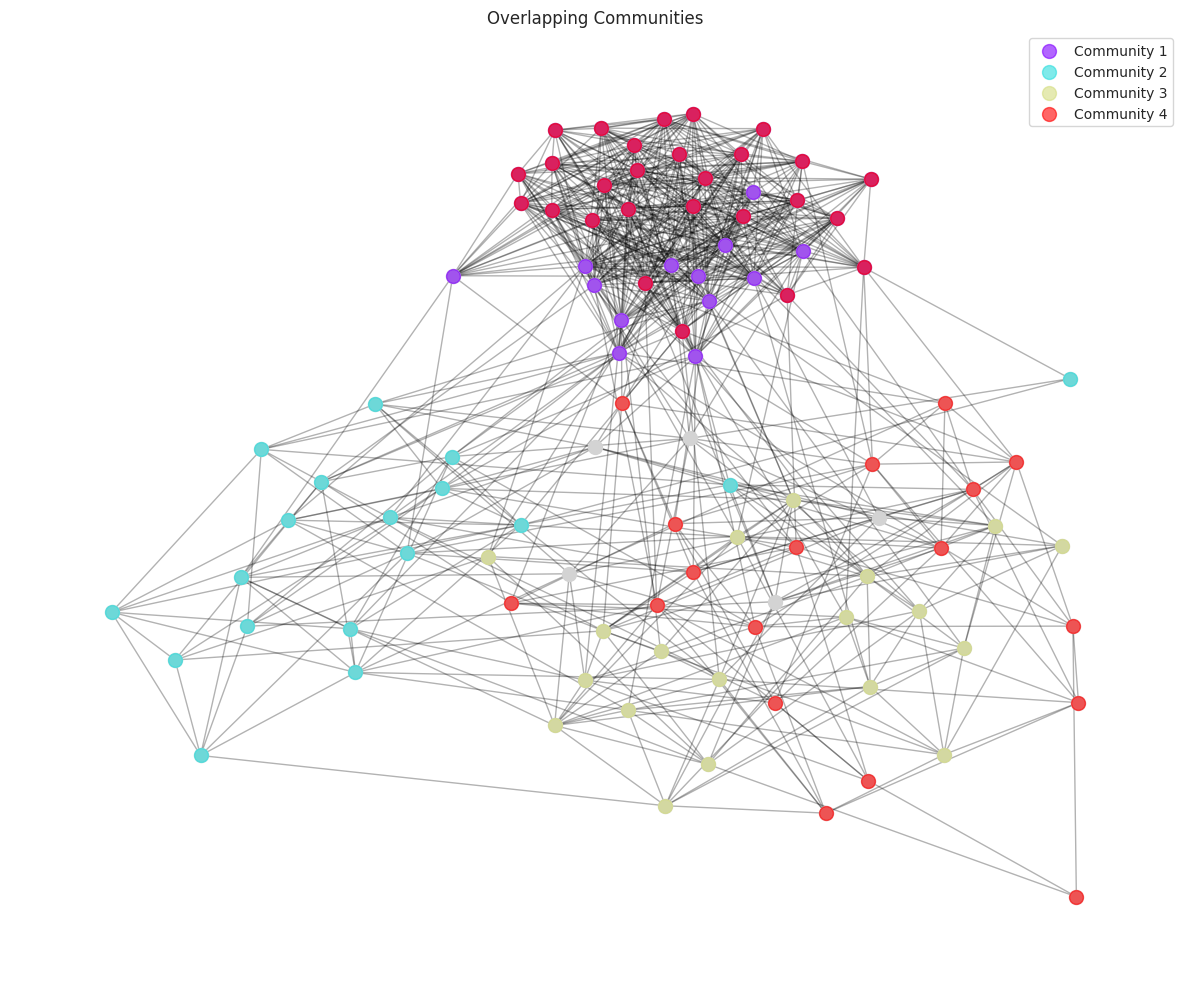

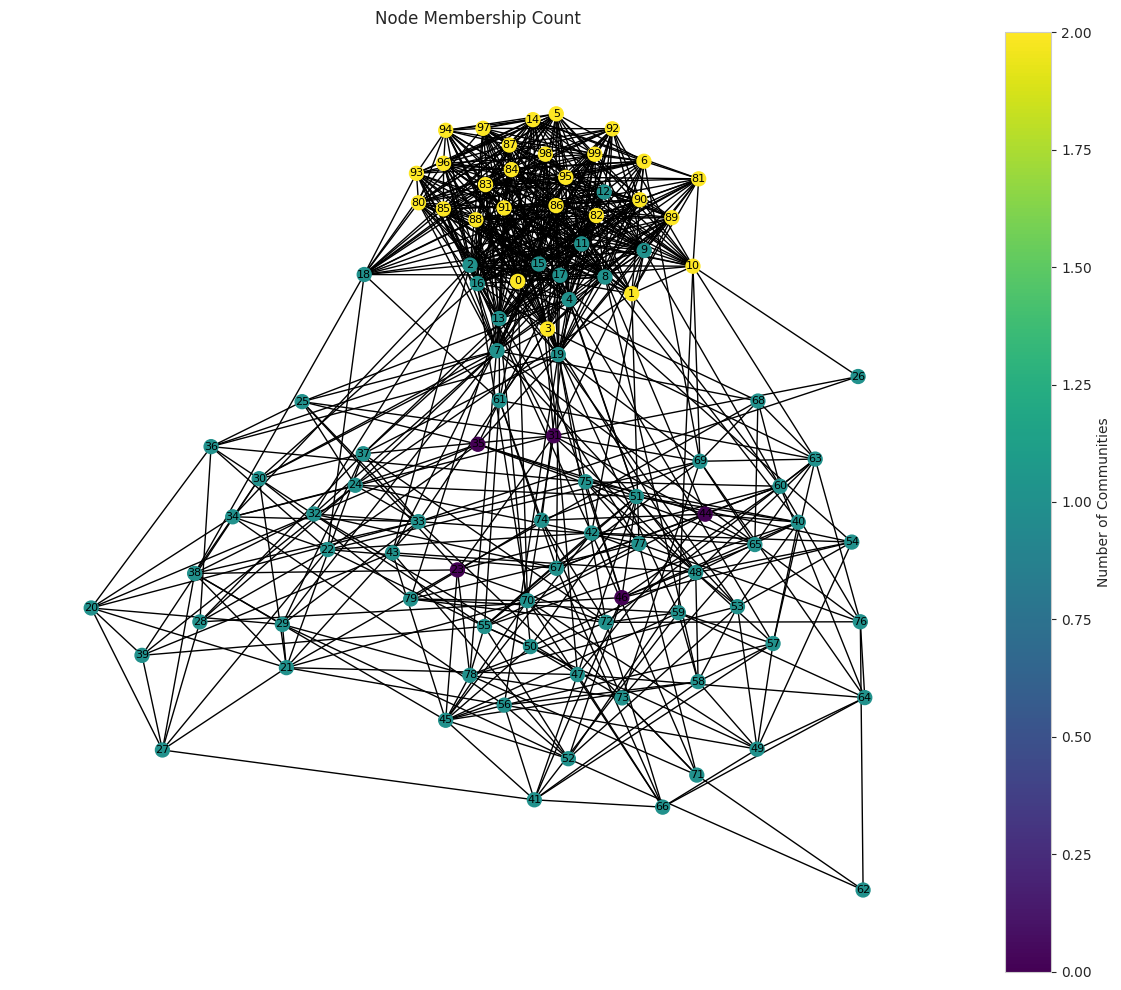

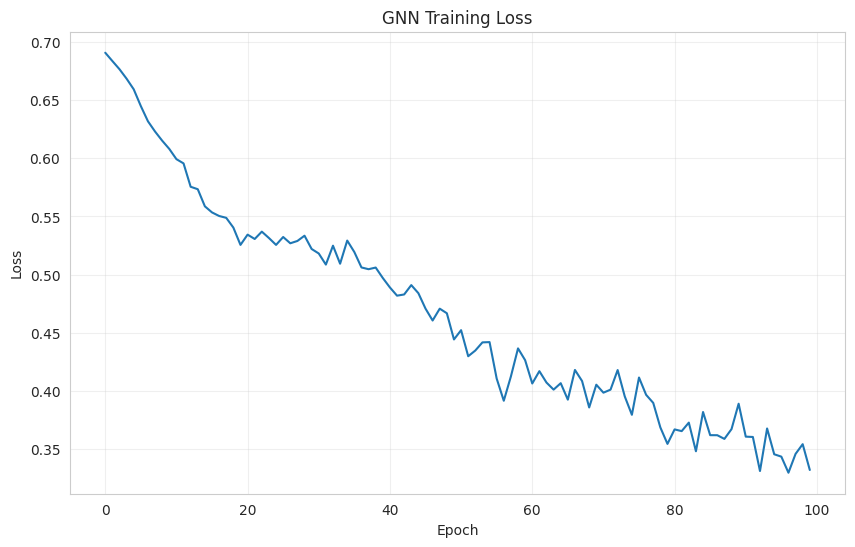

In [9]:
if TORCH_GEOMETRIC_AVAILABLE:
    # Run GNN-based overlapping community detection
    print("Running GNN-based overlapping community detection...")
    
    # Run the GNN model
    gnn_communities, gnn_time, gnn_losses = run_gnn_overlapping(
        G, 
        ground_truth,  # In a real scenario, you would split the data and use cross-validation
        hidden_dim=64,
        epochs=100,
        threshold=0.5
    )
    
    # Evaluate against ground truth
    gnn_metrics = evaluate_overlapping_communities(gnn_communities, ground_truth)
    print(f"Execution time: {gnn_time:.4f} seconds")
    print(f"Number of communities detected: {len(gnn_communities)}")
    print(f"NMI: {gnn_metrics['nmi']:.4f}")
    print(f"Omega Index: {gnn_metrics['omega']:.4f}")
    print(f"F1 Score: {gnn_metrics['f1']:.4f}")
    
    # Save results
    gnn_result = {
        'communities': gnn_communities,
        'execution_time': gnn_time,
        'metrics': gnn_metrics,
        'num_communities': len(gnn_communities),
        'losses': gnn_losses
    }
    with open('results/gnn_overlapping_result.pkl', 'wb') as f:
        pickle.dump(gnn_result, f)
    
    # Visualize detected communities
    print("\nVisualizing GNN detected communities...")
    visualize_overlapping_communities(G, gnn_communities, figsize=(12, 10), alpha=0.6)
    
    # Plot the training loss curve
    plt.figure(figsize=(10, 6))
    plt.plot(gnn_losses)
    plt.title('GNN Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(alpha=0.3)
    plt.show()
else:
    print("GNN-based methods require PyTorch Geometric. Skipping this method.")

## 9. Comparing Overlapping Community Detection Methods

Now, let's run a comprehensive comparison of all the overlapping community detection methods.


Comparison Results:
shape: (4, 7)
┌─────────┬─────────────────┬───────────────┬──────────┬──────────┬──────────┬─────────────────────┐
│ Method  ┆ Num Communities ┆ Avg Community ┆ NMI      ┆ Omega    ┆ F1       ┆ Execution Time (s)  │
│ ---     ┆ ---             ┆ Size          ┆ ---      ┆ ---      ┆ ---      ┆ ---                 │
│ str     ┆ i64             ┆ ---           ┆ f64      ┆ f64      ┆ f64      ┆ f64                 │
│         ┆                 ┆ f64           ┆          ┆          ┆          ┆                     │
╞═════════╪═════════════════╪═══════════════╪══════════╪══════════╪══════════╪═════════════════════╡
│ BigCLAM ┆ 4               ┆ 90.5          ┆ 0.330833 ┆ 0.330833 ┆ 0.559403 ┆ 0.582522            │
│ DEMON   ┆ 2               ┆ 78.0          ┆ 0.316667 ┆ 0.316667 ┆ 0.482498 ┆ 0.079741            │
│ SLPA    ┆ 1               ┆ 100.0         ┆ 0.251667 ┆ 0.251667 ┆ 0.540146 ┆ 0.119351            │
│ GNN     ┆ 4               ┆ 30.5          ┆ 0.795    ┆

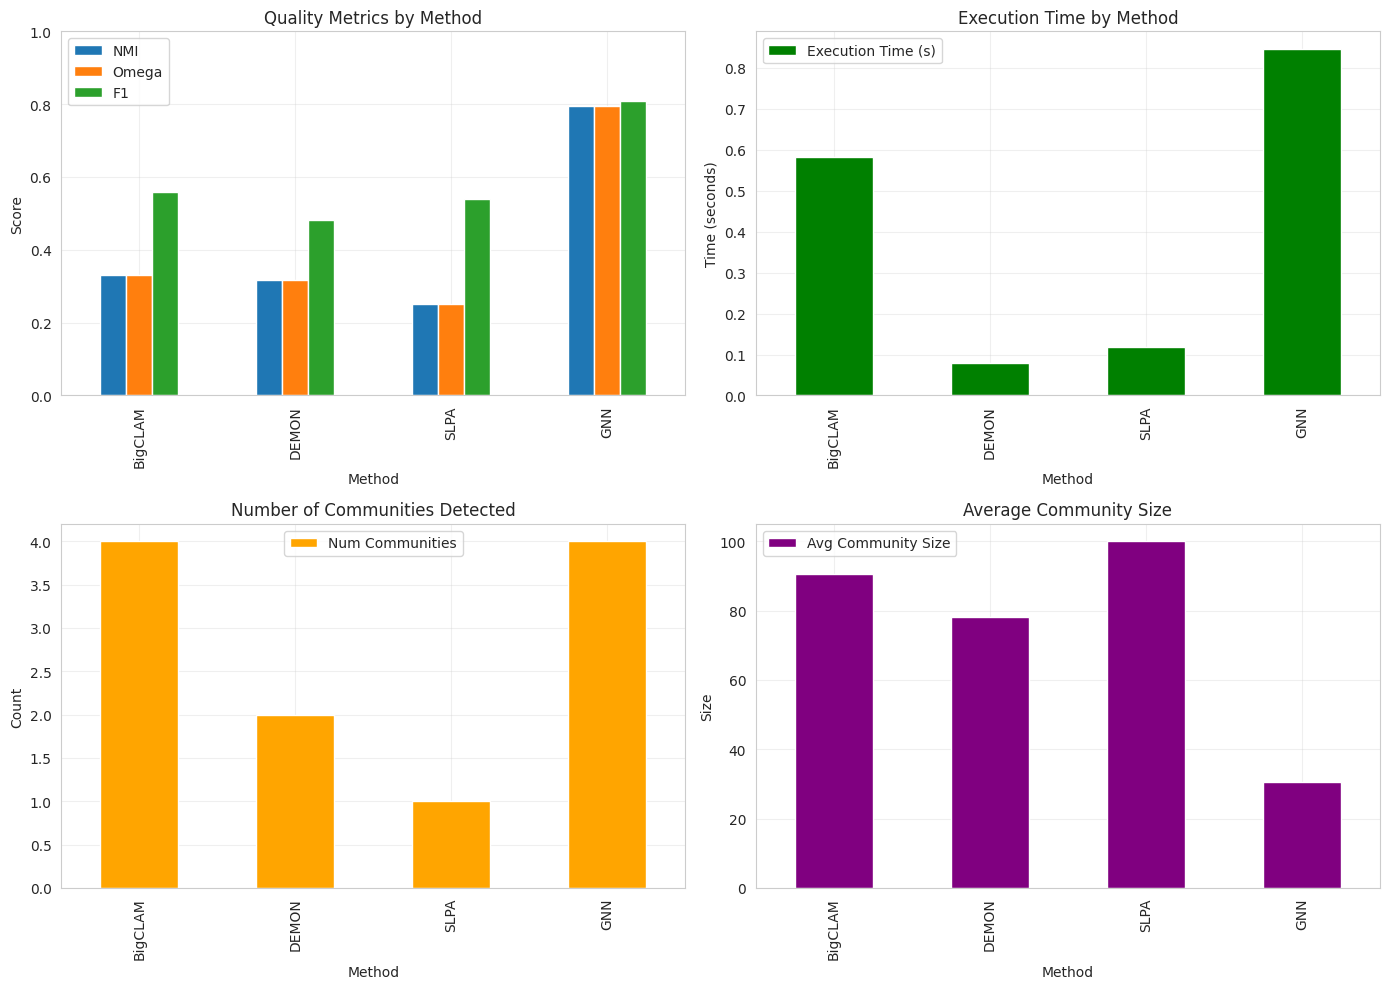

In [10]:
# Check if we have at least one method available
if CDLIB_AVAILABLE or TORCH_GEOMETRIC_AVAILABLE:
    # Set up the results for comparison
    results = []
    
    if CDLIB_AVAILABLE:
        # Add BigCLAM results
        if 'bigclam_metrics' in locals():
            results.append({
                'Method': 'BigCLAM',
                'Num Communities': len(bigclam_communities),
                'Avg Community Size': np.mean([len(comm) for comm in bigclam_communities]),
                'NMI': bigclam_metrics['nmi'],
                'Omega': bigclam_metrics['omega'],
                'F1': bigclam_metrics['f1'],
                'Execution Time (s)': bigclam_time
            })
        
        # Add DEMON results
        if 'demon_metrics' in locals():
            results.append({
                'Method': 'DEMON',
                'Num Communities': len(demon_communities),
                'Avg Community Size': np.mean([len(comm) for comm in demon_communities]),
                'NMI': demon_metrics['nmi'],
                'Omega': demon_metrics['omega'],
                'F1': demon_metrics['f1'],
                'Execution Time (s)': demon_time
            })
        
        # Add SLPA results
        if 'slpa_metrics' in locals():
            results.append({
                'Method': 'SLPA',
                'Num Communities': len(slpa_communities),
                'Avg Community Size': np.mean([len(comm) for comm in slpa_communities]),
                'NMI': slpa_metrics['nmi'],
                'Omega': slpa_metrics['omega'],
                'F1': slpa_metrics['f1'],
                'Execution Time (s)': slpa_time
            })
    
    if TORCH_GEOMETRIC_AVAILABLE:
        # Add GNN results
        if 'gnn_metrics' in locals():
            results.append({
                'Method': 'GNN',
                'Num Communities': len(gnn_communities),
                'Avg Community Size': np.mean([len(comm) for comm in gnn_communities]),
                'NMI': gnn_metrics['nmi'],
                'Omega': gnn_metrics['omega'],
                'F1': gnn_metrics['f1'],
                'Execution Time (s)': gnn_time
            })
    
    # Create DataFrame with results
    if results:
        # Use polars for DataFrame
        comparison_df = pl.DataFrame(results)
        
        # Display results
        print("\nComparison Results:")
        print(comparison_df)
        
        # Save the comparison results
        comparison_df.write_parquet('results/overlapping_methods_comparison.parquet', compression="zstd")
        
        # Convert to pandas for visualization
        comparison_pd = comparison_df.to_pandas()
        
        # Create visualizations
        plt.figure(figsize=(14, 10))
        
        # Plot metrics
        plt.subplot(2, 2, 1)
        comparison_pd.plot(x='Method', y=['NMI', 'Omega', 'F1'], kind='bar', ax=plt.gca())
        plt.title('Quality Metrics by Method')
        plt.ylabel('Score')
        plt.ylim(0, 1)
        plt.grid(alpha=0.3)
        
        # Plot execution time
        plt.subplot(2, 2, 2)
        comparison_pd.plot(x='Method', y='Execution Time (s)', kind='bar', ax=plt.gca(), color='green')
        plt.title('Execution Time by Method')
        plt.ylabel('Time (seconds)')
        plt.grid(alpha=0.3)
        
        # Plot number of communities
        plt.subplot(2, 2, 3)
        comparison_pd.plot(x='Method', y='Num Communities', kind='bar', ax=plt.gca(), color='orange')
        plt.title('Number of Communities Detected')
        plt.ylabel('Count')
        plt.grid(alpha=0.3)
        
        # Plot average community size
        plt.subplot(2, 2, 4)
        comparison_pd.plot(x='Method', y='Avg Community Size', kind='bar', ax=plt.gca(), color='purple')
        plt.title('Average Community Size')
        plt.ylabel('Size')
        plt.grid(alpha=0.3)
        
        plt.tight_layout()
        plt.savefig('results/overlapping_methods_comparison.png')
        plt.show()
    else:
        print("No results available for comparison.")
else:
    print("No methods were run. Please install cdlib or PyTorch Geometric to run the methods.")

## 10. Summary and Conclusions

In this notebook, we have:

1. Generated a synthetic graph with overlapping communities
2. Applied various overlapping community detection methods
   - BigCLAM (if cdlib was available)
   - DEMON (if cdlib was available)
   - SLPA (if cdlib was available)
   - GNN-based approach (if PyTorch Geometric was available)
3. Evaluated the methods using metrics designed for overlapping communities
   - NMI (Normalized Mutual Information)
   - Omega Index
   - F1 Score
4. Visualized the detected overlapping communities
5. Compared the methods in terms of quality and performance

Overlapping community detection is important for many real-world networks where nodes can naturally belong to multiple communities simultaneously, such as in social networks where people can be part of multiple social circles. The methods we've explored provide different approaches to identifying these complex community structures.

In the next notebook, we'll perform a comprehensive evaluation of all the community detection methods we've explored in this series, comparing their performance across different types of graphs and community structures.